Importamos todos los paquetes necesarios para el proyecto:

In [1]:
from search import *
from utils import *
import matplotlib.pyplot as plt
import os
import numpy as np

Definimos la orientación de cada vector

In [2]:
# Vectores de dirección para las orientaciones
orientation_vectors = {
    0: (0, -1),   # North
    1: (1, -1), # Northeast
    2: (1, 0),    # East
    3: (1, 1),  # Southeast
    4: (0, 1),    # South
    5: (-1, 1), # Southwest
    6: (-1, 0),   # West
    7: (-1, -1) # Northwest
}

In [3]:
# Vectores de dirección para las orientaciones
orientation_vectors = {
    0: (-1, 0),   # North
    1: (-1, 1), # Northeast
    2: (0, 1),    # East
    3: (1, 1),  # Southeast
    4: (1, 0),    # South
    5: (1, -1), # Southwest
    6: (0, -1),   # West
    7: (-1, -1) # Northwest
}

## Lectura de los datos

La función `read_map` permite procesar los distintos elementos presentes en el fichero de definición del problema. 

Recibe:
- *file*: nombre del fichero.
- *origin_dir*: directorio en el que está el fichero. Por defecto toma el de trabajo.

Devuelve:
- *dimension*: dimensiones del mapa.
- *map_data*: matriz con el mapa.
- *start_point*: lista de tamaño 3 con el punto y la orientación iniciales.
- *end_point*: lista de tamaño 2 con el punto final.

In [4]:
def read_map(file, origin_dir = os.getcwd()):
    
    file_path = os.path.join(origin_dir, file)
    
    # Abrir y leer el archivo
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Leer la dimensión del mapa (primera línea)
    dimension = list(map(int, lines[0].split()))
    rows, cols = dimension  # Número de filas y columnas

    # Leer el mapa según las dimensiones especificadas
    map_data = np.array([list(map(int, lines[i + 1].split())) for i in range(rows)])

    # Leer el punto inicial y su orientación (penúltima línea)
    start_position = tuple(map(int, lines[-2].split()))

    # Leer el punto final y su orientación (última línea)
    end_position = tuple(map(int, lines[-1].split()))[:2]
    
    return dimension, map_data, start_position, end_position

La función `draw_map` permite representar visualmente el mapa del problema. 

Recibe:
- *dimension*: dimensiones del mapa.
- *map_data*: matriz con el mapa.
- *start_point*: lista de tamaño 3 con el punto y la orientación iniciales.
- *end_point*: lista de tamaño 2 con el punto final.

In [5]:
# Mostrar el mapa en una forma visual usando matplotlib
def draw_map(dimension, map_data, start_position, end_position):
    # Convertir el mapa en una matriz numpy
    map_array = np.array(map_data)
    
    rows, cols = dimension[0], dimension[1]
    
    orientation = start_position[2]

    # Dibujar el mapa
    plt.imshow(map_array, cmap="Blues", origin="upper")
    
    # Agregar los valores de cada celda (peso)
    for i in range(rows):
        for j in range(cols):
            plt.text(j, i, str(map_array[i, j]), color='black', fontsize=12, ha='center', va='center')

    # Agregar el punto inicial y final
    if orientation == 7:
        plt.text(start_position[1]+0.3, start_position[0]+0.3, 'S', color='red', fontsize=12, ha='center', va='center', fontweight='bold')
    else:
        plt.text(start_position[1]-0.3, start_position[0]-0.3, 'S', color='red', fontsize=12, ha='center', va='center', fontweight='bold')
    plt.text(end_position[1]-0.3, end_position[0]-0.3, 'E', color='green', fontsize=12, ha='center', va='center', fontweight='bold')
    
    # Agregar la orientación inicial como una flecha
    arrow_dx, arrow_dy = [x/2 for x in orientation_vectors[orientation]]
    plt.arrow(start_position[1]+arrow_dx/2, start_position[0]+arrow_dy/2, arrow_dx, arrow_dy, head_width=0.1, head_length=0.1, fc='red', ec='red')

    # Configuración de la cuadrícula
    plt.grid(True, color="black", linewidth=1)
    plt.xticks(np.arange(cols))
    plt.yticks(np.arange(rows))

    # Quitar la cuadrícula
    plt.axis('off')

    # Mostrar el mapa
    plt.show()

Dibujamos algunos ejemplos:

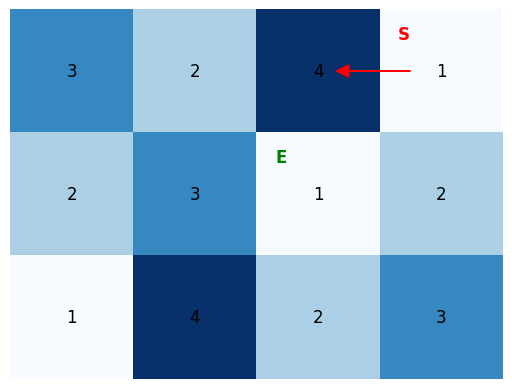

In [6]:
dimension, map_data, start_position, end_position = read_map("exampleMap.txt")
draw_map(dimension, map_data, start_position, end_position)

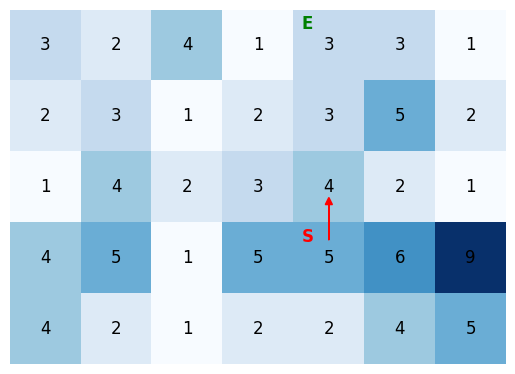

In [7]:
dimension, map_data, start_position, end_position = read_map("exampleMap_2.txt")
draw_map(dimension, map_data, start_position, end_position)

In [8]:
class RobotProblem(Problem):

    def __init__(self, initial, goal, map):
        Problem.__init__(self, initial, goal)
        self.map_data = map_data
        self.dimensions = map_data.shape

    def actions(self, state):
        actions = []
        actions.append((state[0], state[1], (state[2] - 1) % 8))
        actions.append((state[0], state[1], (state[2] + 1) % 8))
        new_position = [state[0] + orientation_vectors[state[2]][0], state[1] + orientation_vectors[state[2]][1]]
        if 0 <= new_position[0] < self.dimensions[0] and 0 <= new_position[1] < self.dimensions[1]:
            actions.append((new_position[0], new_position[1], state[2]))
        return actions
    
    def result(self, state, action):
        return action
    
    def goal_test(self, state):
        return state[:2] == self.goal[:2]
    
    def path_cost(self, cost_so_far, state1, action, state2):
        if state1[:2] == state2[:2]:
            return cost_so_far + 1
        else:
            return cost_so_far + self.map_data[state2[0], state2[1]]

In [9]:
dimension, map_data, start_position, end_position = read_map("exampleMap.txt")
robot_problem = RobotProblem(start_position, end_position, map_data)
robot_problem.map_data

array([[3, 2, 4, 1],
       [2, 3, 1, 2],
       [1, 4, 2, 3]])

In [10]:
def breadth_first_graph_search(problem):
    """[Figure 3.11]
    Note that this function can be implemented in a
    single line as below:
    return graph_search(problem, FIFOQueue())
    """
    node = Node(problem.initial)
    if problem.goal_test(node.state):
        return node
    frontier = deque([node])
    explored = []
    while frontier:
        node = frontier.popleft()
        explored.append(node.state)
        for child in node.expand(problem):
            if child.state not in explored and child not in frontier:
                print(child.state)
                if problem.goal_test(child.state):
                    return child, explored
                frontier.append(child)
    return None

In [11]:
node, explored = breadth_first_graph_search(robot_problem)
print(node.solution())
print(node.path_cost)
print(explored)

(0, 3, 7)
(0, 3, 1)
(0, 3, 6)
(0, 3, 2)
(0, 3, 5)
(0, 2, 6)
(0, 3, 3)
(0, 3, 4)
(1, 2, 5)
[(0, 3, 7), (0, 3, 6), (0, 3, 5), (1, 2, 5)]
4
[(0, 3, 0), (0, 3, 7), (0, 3, 1), (0, 3, 6), (0, 3, 2), (0, 3, 5)]


In [12]:
def depth_first_graph_search(problem):
    """
    [Figure 3.7]
    Search the deepest nodes in the search tree first.
    Search through the successors of a problem to find a goal.
    The argument frontier should be an empty queue.
    Does not get trapped by loops.
    If two paths reach a state, only use the first one.
    """
    frontier = [(Node(problem.initial))]  # Stack

    explored = []
    while frontier:
        node = frontier.pop()
        if problem.goal_test(node.state):
            return node, explored
        explored.append(node.state)
        frontier.extend(child for child in node.expand(problem)
                        if child.state not in explored and child not in frontier)
    return None

In [13]:
node, explored = depth_first_graph_search(robot_problem)
print(node.solution())
print(node.path_cost)
print(explored)

[(0, 3, 1), (0, 3, 2), (0, 3, 3), (0, 3, 4), (1, 3, 4), (2, 3, 4), (2, 3, 5), (2, 3, 6), (2, 2, 6), (2, 1, 6), (2, 0, 6), (2, 0, 7), (2, 0, 0), (1, 0, 0), (0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 1, 2), (0, 2, 2), (0, 2, 3), (0, 2, 4), (1, 2, 4)]
36
[(0, 3, 0), (0, 3, 1), (0, 3, 2), (0, 3, 3), (0, 3, 4), (1, 3, 4), (2, 3, 4), (2, 3, 5), (2, 3, 6), (2, 2, 6), (2, 1, 6), (2, 0, 6), (2, 0, 7), (2, 0, 0), (1, 0, 0), (0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 1, 2), (0, 2, 2), (0, 2, 3), (0, 2, 4)]


In [23]:
def best_first_graph_search(problem, f, display=False):
    """Search the nodes with the lowest f scores first.
    You specify the function f(node) that you want to minimize; for example,
    if f is a heuristic estimate to the goal, then we have greedy best
    first search; if f is node.depth then we have breadth-first search.
    There is a subtlety: the line "f = memoize(f, 'f')" means that the f
    values will be cached on the nodes as they are computed. So after doing
    a best first search you can examine the f values of the path returned."""
    f = memoize(f, 'f')
    node = Node(problem.initial)
    frontier = PriorityQueue('min', f)
    frontier.append(node)
    explored = []
    while frontier:
        node = frontier.pop()
        if problem.goal_test(node.state):
            if display:
                print(len(explored), "paths have been expanded and", len(frontier), "paths remain in the frontier")
            return node, explored
        explored.append(node.state)
        for child in node.expand(problem):
            if child.state not in explored and child not in frontier:
                frontier.append(child)
            elif child in frontier:
                if f(child) < frontier[child]:
                    del frontier[child]
                    frontier.append(child)
    return None

In [24]:
def astar_search(problem, h=None, display=False):
    """A* search is best-first graph search with f(n) = g(n)+h(n).
    You need to specify the h function when you call astar_search, or
    else in your Problem subclass."""
    h = memoize(h or problem.h, 'h')
    return best_first_graph_search(problem, lambda n: n.path_cost + h(n), display)

In [14]:
def chebyshev_distance(start, goal):
    """
    Calculate the Chebyshev distance between two points on a grid.

    Parameters:
    start (tuple): Coordinates of the starting point (x, y).
    goal (tuple): Coordinates of the goal point (x, y).

    Returns:
    int: The Chebyshev distance between the two points.
    """
    x1, y1 = start
    x2, y2 = goal
    
    return max(abs(x2 - x1), abs(y2 - y1))

In [20]:
class RobotProblem_chebyshev(Problem):

    def __init__(self, initial, goal, map):
        Problem.__init__(self, initial, goal)
        self.map_data = map_data
        self.dimensions = map_data.shape

    def actions(self, state):
        actions = []
        actions.append((state[0], state[1], (state[2] - 1) % 8))
        actions.append((state[0], state[1], (state[2] + 1) % 8))
        new_position = [state[0] + orientation_vectors[state[2]][0], state[1] + orientation_vectors[state[2]][1]]
        if 0 <= new_position[0] < self.dimensions[0] and 0 <= new_position[1] < self.dimensions[1]:
            actions.append((new_position[0], new_position[1], state[2]))
        return actions
    
    def result(self, state, action):
        return action
    
    def goal_test(self, state):
        return state[:2] == self.goal[:2]
    
    def path_cost(self, cost_so_far, state1, action, state2):
        if state1[:2] == state2[:2]:
            return cost_so_far + 1
        else:
            return cost_so_far + self.map_data[state2[0], state2[1]]
    
    def h(self, node):
        return chebyshev_distance(node.state[:2], self.goal[:2])

In [25]:
dimension, map_data, start_position, end_position = read_map("exampleMap.txt")
robot_problem_chebyshev = RobotProblem_chebyshev(start_position, end_position, map_data)
robot_problem_chebyshev.map_data

array([[3, 2, 4, 1],
       [2, 3, 1, 2],
       [1, 4, 2, 3]])

In [27]:
node, explored = astar_search(robot_problem_chebyshev)
print(node.solution())
print(explored)

[(0, 3, 7), (0, 3, 6), (0, 3, 5), (1, 2, 5)]
[(0, 3, 0), (0, 3, 1), (0, 3, 7), (0, 3, 2), (0, 3, 6), (0, 3, 3), (0, 3, 5)]


In [18]:
def euclidean_scaled_distance(start, goal):
    
    x1, y1 = start
    x2, y2 = goal
    
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)*np.sqrt(2)/2